In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import time

import numpy as np
import pandas as pd
import plotly.express as px
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from collab.foraging import central_park_birds as cpb
from collab.foraging.central_park_birds.central_park import cp_generate_proximity_score, cp_add_how_far_squared_scaled

import seaborn as sns

from collab.utils import find_repo_root

from functools import reduce

root = find_repo_root()
from collab.foraging import toolkit as ft

logging.basicConfig(format="%(message)s", level=logging.INFO)

# users can ignore smoke_test -- it's for automatic testing on GitHub, to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
num_frames = 5 if smoke_test else 50
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000

import matplotlib.pyplot as plt

notebook_starts = time.time()

Some issues to fix:
- frames input in ft.utils.object_from_data doesn't actually change anything. Either remove input, or make it actually change the frame range.
- ft.animate_foragers plot overflows, check if it returns figure, and if fig can be resized
- ft.animate_foragers assumes no timebins are skipped
- sometimes get comfusing bugs when running on too little data (e.g. just 100 frames)

In [2]:
# load the data
path = os.path.join(root, "data/foraging/gerbils/2020_08_01_18_10_16_589437_compressed_Day_spine (1).npy")
data = np.load(path)

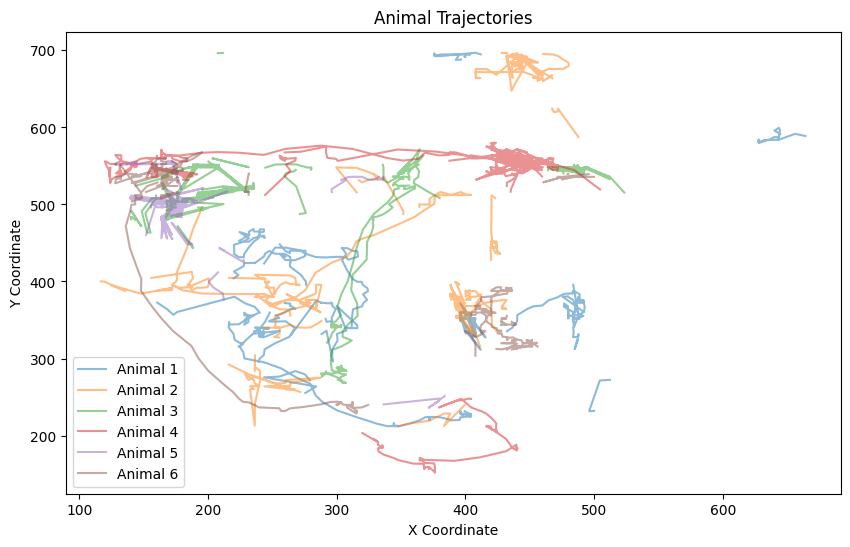

In [3]:
# plot the data
# the dimensions of the data are (time, animal_num, XY)

#  data shape is (time, animal_num, XY)

time_steps, animal_num, _ = data.shape

# Create a plot for each animal's trajectory
plt.figure(figsize=(10, 6))

tmin = 500
tmax = 2000

for i in range(animal_num):
    # Extract the X and Y coordinates for the current animal
    x_coords = data[tmin:tmax, i, 0]
    y_coords = data[tmin:tmax, i, 1]

    # Plot the trajectory
    plt.plot(x_coords, y_coords, label=f"Animal {i+1}", alpha = .5)

# Add labels and a legend
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Animal Trajectories")
plt.legend()

# Show the plot
plt.show()

In [4]:
# Format the data in dataframes as expected for further analysis

# make a dataframe with columns for x, y, time, forager (animal_num), and type (always gerbil)
# Initialize lists to hold the data for the dataframe
time_list = []
forager_list = []
x_list = []
y_list = []
type_list = []

# Populate the lists with the data
for timei in range(time_steps):
    for forager in range(animal_num):
        x_list.append(data[timei, forager, 0])
        y_list.append(data[timei, forager, 1])
        time_list.append(timei)
        forager_list.append(forager)
        type_list.append("gerbil")

# Create the dataframe
gerbil_df = pd.DataFrame(
    {
        "time": time_list,
        "forager": forager_list,
        "x": x_list,
        "y": y_list,
        "type": type_list,
    }
)


# Define the range and location for rewards
x_range = range(250, 651)  # x locations from 250 to 650
y_location = 700  # y location fixed at 700

# Use numpy to efficiently create arrays for the rewards DataFrame
x_array = np.tile(np.arange(250, 651), time_steps)
y_array = np.full(x_array.shape, y_location)
time_array = np.repeat(np.arange(time_steps), len(x_range))

# Create the rewards DataFrame
rewardsDF = pd.DataFrame({"x": x_array, "y": y_array, "time": time_array})

# Remove times where any value in gerbil_df is NaN
nan_times = gerbil_df[gerbil_df.isna().any(axis=1)]["time"]

# Filter gerbil_df to exclude rows with these times
gerbil_df_clean = gerbil_df[~gerbil_df["time"].isin(nan_times)]

# Filter rewardsDF to exclude rows with these times
rewardsDF_clean = rewardsDF[~rewardsDF["time"].isin(nan_times)]

# Display the cleaned DataFrames
print(gerbil_df_clean.head())
print(gerbil_df_clean['time'].unique().shape)
print(rewardsDF_clean.head())

# restrict to time range
gerbil_df_clean = gerbil_df_clean[
    (gerbil_df_clean["time"] >= tmin) & (gerbil_df_clean["time"] <= tmax)
]
rewardsDF_clean = rewardsDF_clean[
    (rewardsDF_clean["time"] >= tmin) & (rewardsDF_clean["time"] <= tmax)
]

forager_object = ft.utils.object_from_data(
    gerbil_df_clean,
    grid_size=1000,
    rewardsDF=rewardsDF_clean,
    frames=None,
    calculate_step_size_max=True,
)

      time  forager           x           y    type
2922   487        0  788.811279  583.877930  gerbil
2923   487        1  395.837769  379.639740  gerbil
2924   487        2  199.334747  504.811859  gerbil
2925   487        3  388.397308  243.945663  gerbil
2926   487        4  180.298141  495.453278  gerbil
(7946,)
          x    y  time
195287  250  700   487
195288  251  700   487
195289  252  700   487
195290  253  700   487
195291  254  700   487


In [5]:
ft.animate_foragers(
    forager_object, plot_rewards=True, width=1000, height=710, point_size=6
)

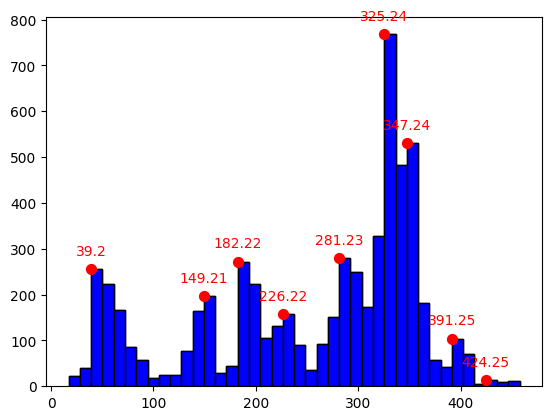

In [6]:
forager_distances = ft.foragers_to_forager_distances(forager_object)
ft.distances_and_peaks(forager_distances)

# this seems multimodal, let's generate different proximity predictors centered approximately around the peaks
# 40, 150, 180, 280, 330

In [13]:
forager_vis = cpb.cp_generate_visibility(forager_object.foragers, 
                                         grid_size = forager_object.grid_size,
                                        visibility_range = 500, sampling_rate=0.001)
forager_object.visibility = forager_vis["visibility"]
forager_object.visibilityDF = forager_vis["visibilityDF"]
display(forager_object.visibilityDF.head())
display(forager_object.visibilityDF.shape)

x    y   distance  distance_x  distance_y  visibility  forager  time
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   785
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   785
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   785
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   785
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   785

(752039, 8)

In [33]:
optimal_candidates = [40, 150, 180, 280, 330]
proximity_dict = {}
for candidate in optimal_candidates:
    proximity_dict[str(candidate)] = cp_generate_proximity_score(forager_object, visibility_range = 500,
                                                   getting_worse = candidate/2,
                                                   optimal = candidate,
                                                   proximity_decay = 0.1,
                                                   forager_distances = forager_distances)

#just to be used by how far, doesnt matter which one we grab here  
forager_object.proximity = proximity_dict["40"]["proximity"]
forager_object.proximityDF = proximity_dict["40"]["proximityDF"]


/home/rafal/s78projects/collaborative-intelligence/collab/foraging/central_park_birds/central_park.py:140: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/home/rafal/s78projects/collaborative-intelligence/collab/foraging/central_park_birds/central_park.py:140: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [34]:
optimal_candidates =  ["40", "150", "180", "280", "330"]

proximity_frames = []

for candidate in optimal_candidates:

    proximity_dict[candidate]['proximityDF'].rename(columns={
        "proximity": f'proximity_{candidate}',
        "proximity_standardized": f'proximity_standardized_{candidate}'
    }, inplace=True)

    proximity_frames.append(proximity_dict[candidate]['proximityDF'])

    display(proximity_dict[candidate]['proximityDF'].head())

result_df = proximity_frames[0]

for i in range(1, len(proximity_frames)):
    proximity_predictors = proximity_frames[i].iloc[:, -5:-3]
    result_df = pd.concat([result_df, proximity_predictors], axis=1)

display(result_df.head())


x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_40  proximity_standardized_40  how_far_squared  \
987231   785  3.089543e-37                  -0.106364         552857.0   
500891   785  1.280025e-19                  -0.106364          47252.0   
733378   785  1.010666e-24                  -0.106364         207418.0   
731479   785  1.002019e-23                  -0.106364         152281.0   
399758   785  1.809231e-12                   0.286558           4018.0   

           how_far  how_far_squared_scaled  
987231  743.543543               -0.353030  
500891  217.375252                0.884358  
733378  455.431663                0.492377  
731479  390.231982                0.627316  
399758   63.387696                0.990167

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_150  proximity_standardized_150  how_far_squared  \
987231   785   2.893632e-31                   -0.106364         552857.0   
500891   785   1.198857e-13                   -0.106364          47252.0   
733378   785   9.465785e-19                   -0.106364         207418.0   
731479   785   9.384800e-18                   -0.106364         152281.0   
399758   785   1.694506e-06                    0.286558           4018.0   

           how_far  how_far_squared_scaled  
987231  743.543543               -0.353030  
500891  217.375252                0.884358  
733378  455.431663                0.492377  
731479  390.231982                0.627316  
399758   63.387696                0.990167

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_180  proximity_standardized_180  how_far_squared  \
987231   785   1.230404e-29                   -0.106364         552857.0   
500891   785   5.097671e-12                   -0.106364          47252.0   
733378   785   4.024954e-17                   -0.106364         207418.0   
731479   785   3.990518e-16                   -0.106364         152281.0   
399758   785   7.205225e-05                    0.286558           4018.0   

           how_far  how_far_squared_scaled  
987231  743.543543               -0.353030  
500891  217.375252                0.884358  
733378  455.431663                0.492377  
731479  390.231982                0.627316  
399758   63.387696                0.990167

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_280  proximity_standardized_280  how_far_squared  \
987231   785   3.301632e-24                   -0.283715         552857.0   
500891   785   1.367895e-06                   -0.283708          47252.0   
733378   785   1.080045e-11                   -0.283715         207418.0   
731479   785   1.070805e-10                   -0.283715         152281.0   
399758   785   9.154424e-01                    4.083625           4018.0   

           how_far  how_far_squared_scaled  
987231  743.543543               -0.353030  
500891  217.375252                0.884358  
733378  455.431663                0.492377  
731479  390.231982                0.627316  
399758   63.387696                0.990167

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_330  proximity_standardized_330  how_far_squared  \
987231   785   1.710288e-21                   -0.404004         552857.0   
500891   785   7.085872e-04                   -0.401665          47252.0   
733378   785   5.594773e-09                   -0.404004         207418.0   
731479   785   5.546907e-08                   -0.404003         152281.0   
399758   785   9.922519e-01                    2.871162           4018.0   

           how_far  how_far_squared_scaled  
987231  743.543543               -0.353030  
500891  217.375252                0.884358  
733378  455.431663                0.492377  
731479  390.231982                0.627316  
399758   63.387696                0.990167

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  15.055602  576.073303  462.737732    0.998882        1   
500891  501  892  23.930548   89.073303  197.262268    0.997175        1   
733378  734  379   3.559655  322.073303  315.737732    0.999937        1   
731479  732  480  14.514515  320.073303  214.737732    0.998961        1   
399758  400  759  10.230892   11.926697   64.262268    0.999484        1   

        time  proximity_40  proximity_standardized_40  ...     how_far  \
987231   785  3.089543e-37                  -0.106364  ...  743.543543   
500891   785  1.280025e-19                  -0.106364  ...  217.375252   
733378   785  1.010666e-24                  -0.106364  ...  455.431663   
731479   785  1.002019e-23                  -0.106364  ...  390.231982   
399758   785  1.809231e-12                   0.286558  ...   63.387696   

        how_far_squared_scaled  proximity_150  proximity_standardized_150  \
987231               -0.353030   2.893632e-31                   -0.106364   
500891                0.884358   1.198857e-13                   -0.106364   
733378                0.492377   9.465785e-19                   -0.106364   
731479                0.627316   9.384800e-18                   -0.106364   
399758                0.990167   1.694506e-06                    0.286558   

        proximity_180  proximity_standardized_180  proximity_280  \
987231   1.230404e-29                   -0.106364   3.301632e-24   
500891   5.097671e-12                   -0.106364   1.367895e-06   
733378   4.024954e-17                   -0.106364   1.080045e-11   
731479   3.990518e-16                   -0.106364   1.070805e-10   
399758   7.205225e-05                    0.286558   9.154424e-01   

        proximity_standardized_280  proximity_330  proximity_standardized_330  
987231                   -0.283715   1.710288e-21                   -0.404004  
500891                   -0.283708   7.085872e-04                   -0.401665  
733378                   -0.283715   5.594773e-09                   -0.404004  
731479                   -0.283715   5.546907e-08                   -0.404003  
399758                    4.083625   9.922519e-01                    2.871162  

[5 rows x 21 columns]

In [ ]:
# cp_add_how_far_squared_scaled(forager_object)

# forager_object.how_farDF.head()

# result_df = pd.concat([result_df, forager_object.how_farDF.iloc[:, -3:]], axis=1)
# display(result_df.head())


In [35]:
result_df.drop(columns = ["distance_x", "distance_y"], inplace=True)

result_df['forager'] = result_df['forager'].astype('category')
result_df['forager_id'] = result_df['forager'].cat.codes
result_df.drop(columns = ["forager"], inplace=True)

result_df['time'] = result_df['time'].astype('category')
result_df['time_id'] = result_df['time'].cat.codes
result_df.drop(columns = ["time"], inplace=True)


display(result_df.head())

predictors = {key: torch.tensor(result_df[key].values) for key in result_df.columns}


x    y   distance  visibility  proximity_40  \
987231  988  232  15.055602    0.998882  3.089543e-37   
500891  501  892  23.930548    0.997175  1.280025e-19   
733378  734  379   3.559655    0.999937  1.010666e-24   
731479  732  480  14.514515    0.998961  1.002019e-23   
399758  400  759  10.230892    0.999484  1.809231e-12   

        proximity_standardized_40  how_far_squared     how_far  \
987231                  -0.106364         552857.0  743.543543   
500891                  -0.106364          47252.0  217.375252   
733378                  -0.106364         207418.0  455.431663   
731479                  -0.106364         152281.0  390.231982   
399758                   0.286558           4018.0   63.387696   

        how_far_squared_scaled  proximity_150  proximity_standardized_150  \
987231               -0.353030   2.893632e-31                   -0.106364   
500891                0.884358   1.198857e-13                   -0.106364   
733378                0.492377   9.465785e-19                   -0.106364   
731479                0.627316   9.384800e-18                   -0.106364   
399758                0.990167   1.694506e-06                    0.286558   

        proximity_180  proximity_standardized_180  proximity_280  \
987231   1.230404e-29                   -0.106364   3.301632e-24   
500891   5.097671e-12                   -0.106364   1.367895e-06   
733378   4.024954e-17                   -0.106364   1.080045e-11   
731479   3.990518e-16                   -0.106364   1.070805e-10   
399758   7.205225e-05                    0.286558   9.154424e-01   

        proximity_standardized_280  proximity_330  proximity_standardized_330  \
987231                   -0.283715   1.710288e-21                   -0.404004   
500891                   -0.283708   7.085872e-04                   -0.401665   
733378                   -0.283715   5.594773e-09                   -0.404004   
731479                   -0.283715   5.546907e-08                   -0.404003   
399758                    4.083625   9.922519e-01                    2.871162   

        forager_id  time_id  
987231           0        0  
500891           0        0  
733378           0        0  
731479           0        0  
399758           0        0

/home/rafal/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/rafal/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



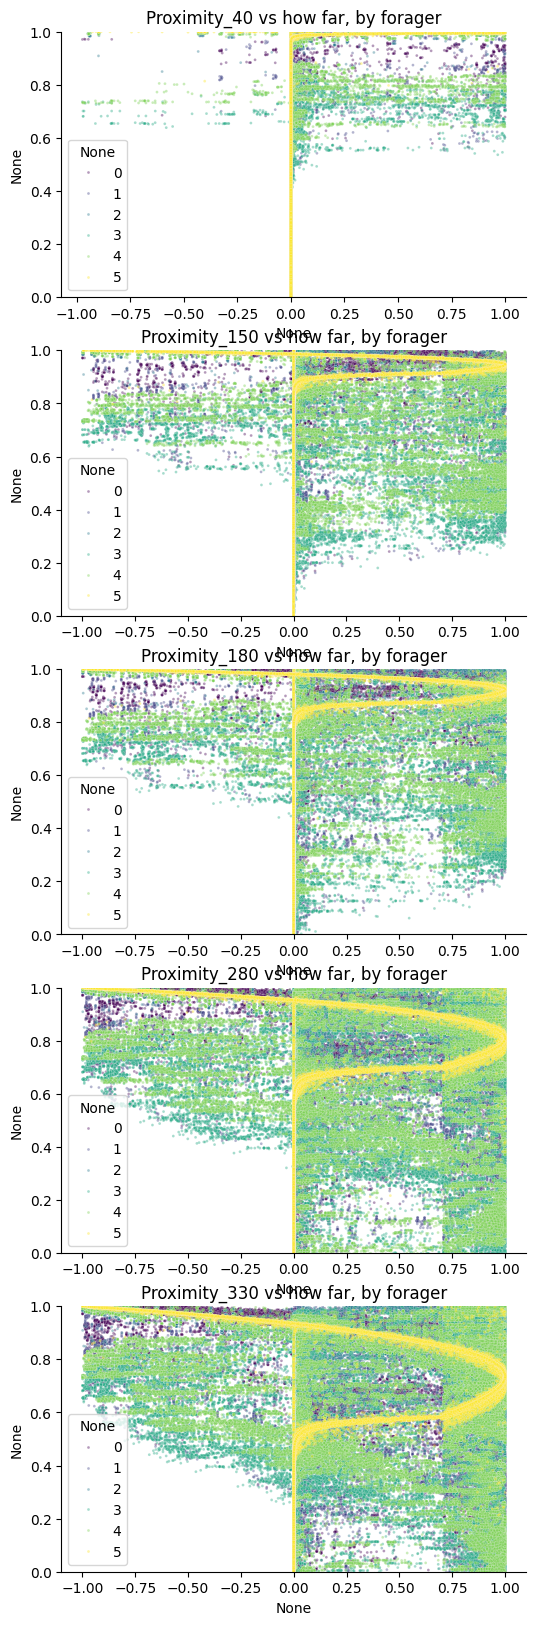

In [38]:

fig, axes = plt.subplots(len(optimal_candidates), 1, figsize=(6, len(optimal_candidates) * 4))

if len(optimal_candidates) == 1:
    axes = [axes]

for i, (proximity, ax) in enumerate(zip(optimal_candidates, axes)):
    sns.scatterplot(x=predictors[f'proximity_{proximity}'], 
                    y=predictors['how_far_squared_scaled'], 
                    hue=predictors['forager_id'], 
                    palette='viridis', 
                    s=4, alpha=0.4, ax=ax)
    
    ax.set_ylim(0, 1)
    ax.set_title(f"Proximity_{proximity} vs how far, by forager")
    sns.despine()

In [43]:
class  GerbilModel(pyro.nn.PyroModule):
    def __init__(
        self,
        predictors: dict,
        leeway=0.9,
    ):
        super().__init__()

        self.predictors = predictors
        self.leeway = leeway
        self.n = len(predictors["forager_id"])

        
    def forward(
        self,
        leeway=0.4,
    ):
        
        pass

gerbil_40_model = GerbilModel(predictors)




752039

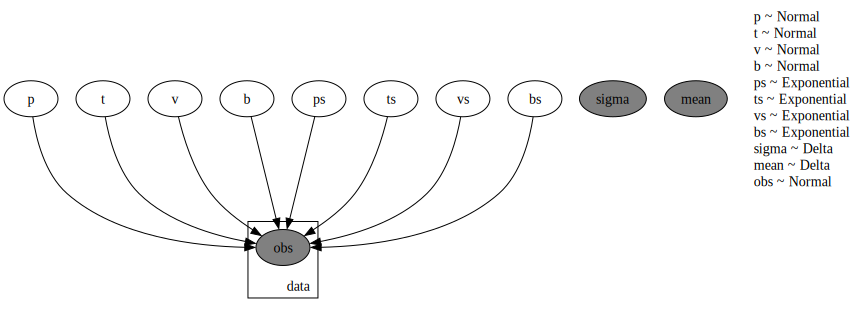

In [30]:
#full pooling, just proximity 40

def model_sigmavar(proximity, trace, visibility, how_far_score):
    p = pyro.sample("p", dist.Normal(0, 0.2))
    t = pyro.sample("t", dist.Normal(0, 0.2))
    v = pyro.sample("v", dist.Normal(0, 0.2))
    b = pyro.sample("b", dist.Normal(0.5, 0.3))

    ps = pyro.sample("ps", dist.Exponential(7))
    ts = pyro.sample("ts", dist.Exponential(7))
    vs = pyro.sample("vs", dist.Exponential(7))
    bs = pyro.sample("bs", dist.Exponential(7))

    sigma = pyro.deterministic(
        "sigma", bs + ps * proximity + ts * trace + vs * visibility
    )
    mean = pyro.deterministic("mean", b + p * proximity + t * trace + v * visibility)

    with pyro.plate("data", len(how_far_score)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=how_far_score)


pyro.render_model(
    model_sigmavar,
    model_args=(proximity, trace, visibility, how_far_score),
    render_distributions=True,
)

In [31]:
# helper functions for inference, showing results


def summary(samples, sites):
    site_stats = {}
    for site_name, values in samples.items():
        if site_name in sites:
            marginal_site = pd.DataFrame(values)
            describe = marginal_site.describe(
                percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]
            ).transpose()
            site_stats[site_name] = describe[
                ["mean", "std", "5%", "25%", "50%", "75%", "95%"]
            ]
    return site_stats


def get_samples(
    proximity,
    trace,
    visibility,
    how_far_score,
    model=model_sigmavar,
    num_svi_iters=num_svi_iters,
    num_samples=num_samples,
):
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model_sigmavar, guide, optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    iterations = []
    losses = []

    logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
    start_time = time.time()
    pyro.clear_param_store()
    for i in range(num_svi_iters):
        elbo = svi.step(proximity, trace, visibility, how_far_score)
        iterations.append(i)
        losses.append(elbo)
        if i % 200 == 0:
            logging.info("Elbo loss: {}".format(elbo))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

    if not smoke_test:
        fig = px.line(
            x=iterations, y=losses, title="ELBO loss", template="presentation"
        )
        labels = {"iterations": "iteration", "losses": "loss"}
        fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
        fig.update_yaxes(showgrid=False, title_text=labels["losses"])
        fig.update_layout(width=700)
        fig.show()

    predictive = Predictive(
        model, guide=guide, num_samples=num_samples, return_sites=["t", "p", "v"]
    )
    rhf_svi = {
        k: v.flatten().reshape(num_samples, -1).detach().cpu().numpy()
        for k, v in predictive(proximity, trace, visibility, how_far_score).items()
        if k != "obs"
    }

    print("SVI-based coefficient marginals:")
    for site, values in summary(rhf_svi, ["t", "p", "v"]).items():
        print("Site: {}".format(site))
        print(values, "\n")

    return {"svi_samples": rhf_svi, "svi_guide": guide, "svi_predictive": predictive}


def calculate_R_squared(guide):
    predictive = pyro.infer.Predictive(model_sigmavar, guide=guide, num_samples=1000)
    predictions = predictive(proximity, trace, visibility, how_far_score)

    simulated_outcome = (
        predictions["b"]
        + predictions["p"] * proximity
        + predictions["t"] * trace
        + predictions["v"] * visibility
    )

    mean_sim_outcome = simulated_outcome.mean(0).detach().cpu().numpy()

    observed_mean = torch.mean(how_far_score)

    tss = torch.sum((how_far_score - observed_mean) ** 2)
    rss = torch.sum((how_far_score - mean_sim_outcome) ** 2)

    r_squared = 1 - (rss / tss)

    return r_squared.float().item()

In [32]:
# Diagnose issue... proximity is all NaNs.
proximity.isnan().sum()

tensor(0)

In [33]:
samples_random = get_samples(proximity, trace, visibility, how_far_score)

2024-08-06 08:47:53,196 - Starting SVI inference with 1000 iterations.
2024-08-06 08:47:53,320 - Elbo loss: 8457667.020689905
2024-08-06 08:48:06,316 - Elbo loss: -4660539.745828688
2024-08-06 08:48:19,454 - Elbo loss: -4968641.054060578
2024-08-06 08:48:31,238 - Elbo loss: -6286645.990968227
2024-08-06 08:48:43,249 - Elbo loss: -6021450.261303484
2024-08-06 08:48:56,052 - SVI inference completed in 62.85 seconds.


SVI-based coefficient marginals:
Site: p
       mean       std        5%       25%       50%       75%      95%
0  0.009313  0.020598 -0.025037 -0.005398  0.010175  0.023043  0.04269 

Site: t
       mean       std        5%       25%       50%       75%       95%
0  0.006825  0.013833 -0.015208 -0.001996  0.006247  0.016113  0.030024 

Site: v
      mean       std        5%       25%       50%       75%       95%
0  0.17893  0.015536  0.153004  0.168402  0.178868  0.189767  0.203834 



In [34]:
ft.plot_coefs(samples_random, "Gerbils", nbins=120, ann_start_y=160, ann_break_y=50)